In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Get best fit parameters

In [3]:
id = (133, 0)
with open('./../results/results_ring_'+str(id[0])+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)[id[1]]
    prms = res_dict['prms']
    eX = res_dict['best_monk_eX']
    bX = res_dict['best_monk_bX']
    aXs = res_dict['best_monk_aXs']
    K = prms['K']
    SoriE = prms['SoriE']
    SoriI = prms['SoriI']
    SoriF = prms['SoriF']
#     J = prms['J']
#     beta = prms['beta']
#     gE = prms['gE']
#     gI = prms['gI']
#     hE = prms['hE']
#     hI = prms['hI']
    L = prms['L']
#     CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,8*Nt,round(8*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 10000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


# Simulate unstructured network, where peak input goes to all locations

In [4]:
reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor([0],this_prms,eX)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*H)*eps,LAS,net.C_conds[0],mult_tau=True)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,L,M,((bX+aXs[-1])*H)*eps,LAS,net.C_conds[0],mult_tau=True)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()

np.save('unstruct_opto_sol',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  5.972906  s

Integrating network took  1325.554528  s



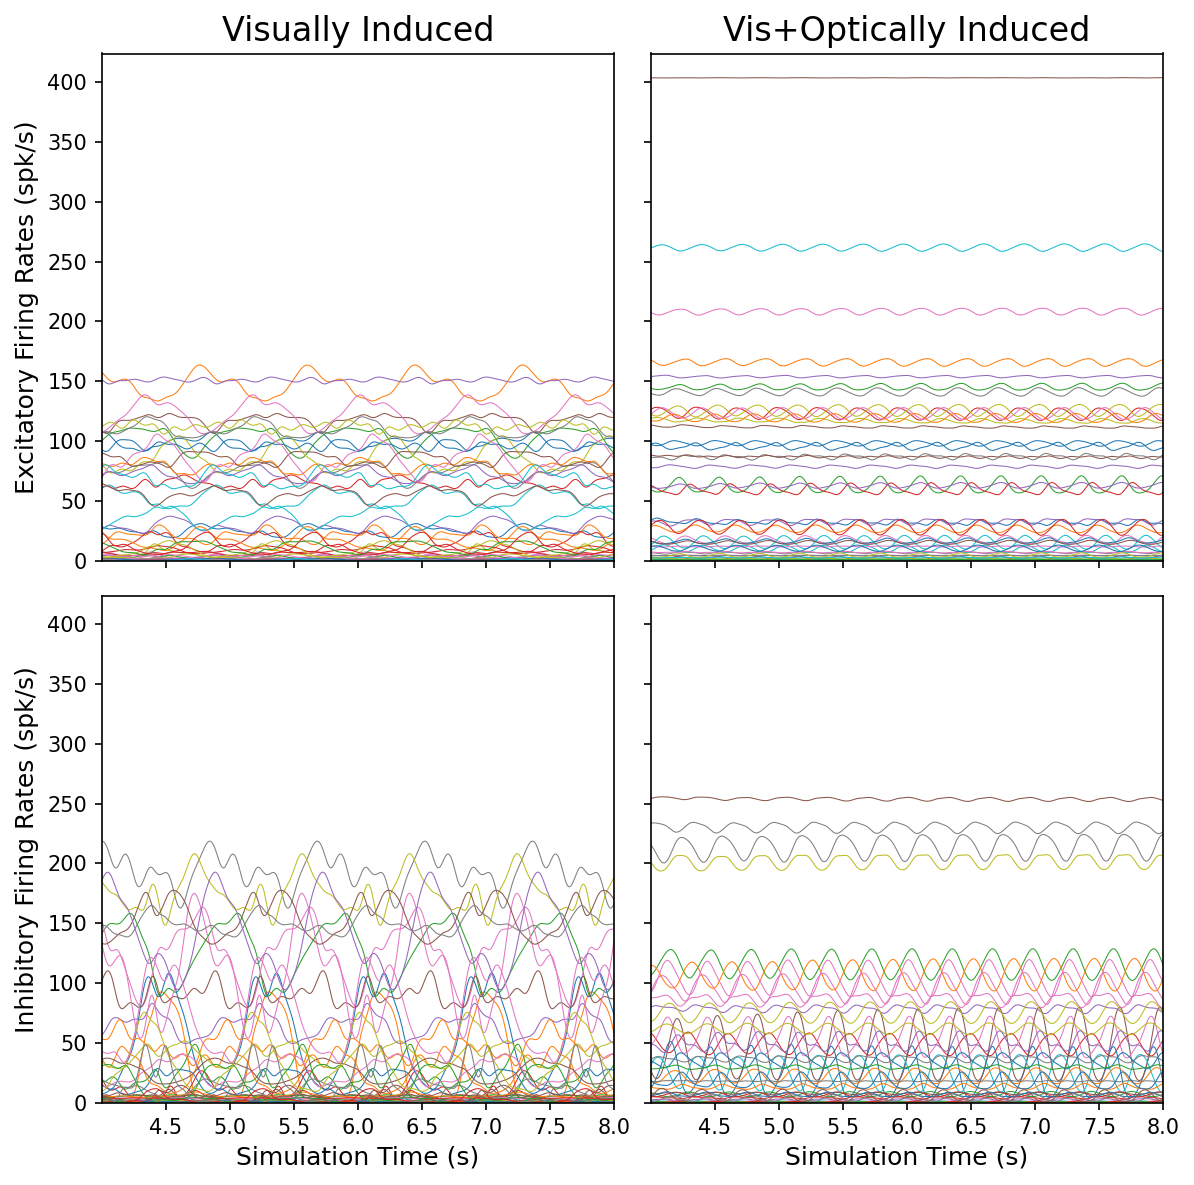

In [7]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,base_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(T_mask,opto_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,base_dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(T_mask,opto_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title('Visually Induced',fontsize=16)
axs[0,1].set_title('Vis+Optically Induced',fontsize=16)

fig.tight_layout()
fig.savefig('./../plots/time_discr')

In [5]:
np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates)

-0.05158949485566698

# Find level of increased disorder that gives reshuffling

In [ ]:
disord_factor = 1.5

disord_prms = this_prms.copy()
disord_prms['K'] = int(this_prms['K']/disord_factor)
disord_prms['J'] = this_prms['J']*(this_prms['K']/disord_prms['K'])

reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor([0],disord_prms,eX)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*H)*eps,LAS,net.C_conds[0],mult_tau=True)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol_more_disord',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,L,M,((bX+aXs[-1])*H)*eps,LAS,net.C_conds[0],mult_tau=True)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()
np.save('unstruct_opto_sol_more_disord',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol_more_disord.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol_more_disord.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  7.952193000000079  s

Integrating base network took  1098.4129390000003  s



In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,base_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(T_mask,opto_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,base_dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(T_mask,opto_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title('Visually Induced',fontsize=16)
axs[0,1].set_title('Vis+Optically Induced',fontsize=16)

fig.tight_layout()
fig.savefig('./../plots/time_discr')

In [ ]:
np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates)